In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
default_S = 5000
default_K = 5000
default_r = 0.049
default_y = 0.011
default_sigma = 0.155
default_T = 1

# Problem 1a
def box_muller(u1, u2):
    z0 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z1 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return z0, z1

def sobolNormalGen(length, dim, seed = 666):
    sobol_engine = stats.qmc.Sobol(2*dim, bits=64, seed=seed)
    uniform = sobol_engine.random(length)
    samples = np.zeros((2*length, dim))
    for i in range(dim):
        z0, z1 = box_muller(uniform[:, 2*i], uniform[:, 2*i+1])
        tempArray = np.zeros((length, 2))
        tempArray[:, 0] = z0
        tempArray[:, 1] = z1
        samples[:, i] = tempArray.flatten()
    return samples

def stockSample(samples, S0 = default_S, r = default_r, y=default_y, sigma = default_sigma, T = default_T):
    dt = T/samples.shape[1]
    S = np.zeros((samples.shape[0], samples.shape[1]+1))
    S[:, 0] = S0
    for i in range(1, samples.shape[1]+1):
        S[:, i] = S[:, i-1] * np.exp((r - y - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * samples[:, i-1])
    return S


sobol_3 = sobolNormalGen(1000, 1)
sobol_4 = sobolNormalGen(10000, 1)
sobol_5 = sobolNormalGen(100000, 1)
sobol_6 = sobolNormalGen(1000000, 1)

sobol_3_stock = stockSample(sobol_3)
sobol_4_stock = stockSample(sobol_4)
sobol_5_stock = stockSample(sobol_5)
sobol_6_stock = stockSample(sobol_6)


print(sobol_3_stock[:, 1])


[6444.15978945 8080.21888132 5545.4340558  ... 5800.09060956 4514.98642137
 4079.6156982 ]


In [17]:
def momentStats(arr, consoleLog=False, asset=False):
    mean = np.mean(arr)
    variance = np.var(arr)
    sdev = np.std(arr)
    if asset:
        logMean = np.mean(np.log(arr))
        logVariance = np.var(np.log(arr))
        logSdev = np.std(np.log(arr))
    if print:
        print("Mean:", mean)
        print("Variance:", variance)
        print("Standard Deviation:", sdev)
        if asset:
            print("Log Mean:", logMean)
            print("Log Variance:", logVariance)
            print("Log Standard Deviation:", logSdev)
        return
    if asset:
        return mean, variance, sdev, logMean, logVariance, logSdev
    return mean, variance, sdev

# Print the results
print("Array Size: 1000")
momentStats(sobol_3, consoleLog=True)

print("Array Size: 10000")
momentStats(sobol_4, consoleLog=True)

print("Array Size: 100000")
momentStats(sobol_5, consoleLog=True)

print("Array Size: 1000000")
momentStats(sobol_6, consoleLog=True)


Array Size: 1000
Mean: -0.00013859162531406133
Variance: 0.9983815431779776
Standard Deviation: 0.999190443898448
Array Size: 10000
Mean: -0.00010659732602558303
Variance: 1.0002417017942762
Standard Deviation: 1.0001208435955509
Array Size: 100000
Mean: 9.990618322101917e-06
Variance: 0.9999988174567274
Standard Deviation: 0.9999994087281889
Array Size: 1000000
Mean: -6.659640262826371e-08
Variance: 0.9999994882489914
Standard Deviation: 0.999999744124463


In [18]:
momentStats(sobol_3_stock[:,1], consoleLog=True, asset=True)
momentStats(sobol_4_stock[:,1], consoleLog=True, asset=True)
momentStats(sobol_5_stock[:,1], consoleLog=True, asset=True)
momentStats(sobol_6_stock[:,1], consoleLog=True, asset=True)


Mean: 5193.502841180549
Variance: 656546.5311328218
Standard Deviation: 810.2755896192491
Log Mean: 8.543159209714315
Log Variance: 0.023986116574850908
Log Standard Deviation: 0.15487451880425943
Mean: 5193.578150430015
Variance: 655794.6794525896
Standard Deviation: 809.8115085948024
Log Mean: 8.543164168830703
Log Variance: 0.024030806885607485
Log Standard Deviation: 0.15501873075731037
Mean: 5193.66416017122
Variance: 655902.9925171373
Standard Deviation: 809.8783813123655
Log Mean: 8.543182239962077
Log Variance: 0.02402497158939787
Log Standard Deviation: 0.15499990835286925


Mean: 5193.656186837409
Variance: 655903.0332668655
Standard Deviation: 809.8784064702958
Log Mean: 8.543180681093796
Log Variance: 0.024024987705182018
Log Standard Deviation: 0.15499996033929175


In [19]:
def callSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        samples = stockSample(samples, S, r, y, sigma, T)[:, 1]
    else:
        raise ValueError("Samples must be 1D array")
    return np.exp(-r * default_T) * np.maximum(samples - K, 0)

def putSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        samples = stockSample(samples, S, r, y, sigma, T)[:, 1]
    else:
        raise ValueError("Samples must be 1D array")
    return np.exp(-r * default_T) * np.maximum(K - samples, 0)

#For Problem 2
def logPutSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        stockPrices = stockSample(samples, S, r, y, sigma, T)[:, 1]
    else:
        raise ValueError("Samples must be 1D array")
    for i in range(len(stockPrices)):
        stockPrices[i] = np.minimum(K, stockPrices[i])
    return K*np.exp(-r * default_T) * (np.log(K) - np.log(stockPrices))

def logCallSim(samples, S, K, r, y, sigma, T): 
    if samples.shape[1] == 1:
        stockPrices = stockSample(samples, S, r, y, sigma, T)[:, 1]
    else:
        raise ValueError("Samples must be 1D array")
    for i in range(len(stockPrices)):
        stockPrices[i] = np.maximum(K, stockPrices[i])
    return K*np.exp(-r * default_T) * (np.log(stockPrices) - np.log(K))

def antitheticCallSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        samples_plus = stockSample(samples, S, r, y, sigma, T)[:, 1]
        samples_minus = stockSample(-1*samples, S, r, y, sigma, T)[:, 1]
    else:
        raise ValueError("Samples must be 1D array")
    return 0.5*np.exp(-r * default_T) * (np.maximum(samples_plus - K, 0) + np.maximum(samples_minus - K, 0))

def antitheticPutSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        samples_plus = stockSample(samples, S, r, y, sigma, T)[:, 1]
        samples_minus = stockSample(-1*samples, S, r, y, sigma, T)[:, 1]
    else:
        raise ValueError("Samples must be 1D array")
    return 0.5*np.exp(-r * default_T) * (np.maximum(K - samples_plus, 0) + np.maximum(K - samples_minus, 0))

#For the sake of completeness
def antitheticLogCallSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        stockPrices = stockSample(samples, S, r, y, sigma, T)
        stockPrices_minus = stockSample(-1*samples, S, r, y, sigma, T)
    else:
        raise ValueError("Samples must be 1D array")
    for i in range(len(stockPrices)):
        stockPrices[i] = np.maximum(K, stockPrices[i])
        stockPrices_minus[i] = np.maximum(K, stockPrices_minus[i])
    return K*np.exp(-r * default_T) * (np.log(stockPrices) - np.log(K) + np.log(stockPrices_minus) - np.log(K))

def antitheticLogPutSim(samples, S, K, r, y, sigma, T):
    if samples.shape[1] == 1:
        stockPrices = stockSample(samples, S, r, y, sigma, T)
        stockPrices_minus = stockSample(-1*samples, S, r, y, sigma, T)
    else:
        raise ValueError("Samples must be 1D array")
    for i in range(len(stockPrices)):
        stockPrices[i] = np.minimum(K, stockPrices[i])
        stockPrices_minus[i] = np.minimum(K, stockPrices_minus[i])
    return K*np.exp(-r * default_T) * (np.log(K) - np.log(stockPrices) + np.log(K) - np.log(stockPrices_minus))


# For Problems 1 & 2
def simSwitch(samples, S, K, r, y, sigma, T, optionType, method):
    if optionType == "call":
        if method == "standard":
            return callSim(samples, S, K, r, y, sigma, T)
        if method == "antithetic":
            return antitheticCallSim(samples, S, K, r, y, sigma, T)
    if optionType == "put":
        if method == "standard":
            return putSim(samples, S, K, r, y, sigma, T)
        if method == "antithetic":
            return antitheticPutSim(samples, S, K, r, y, sigma, T)
    if optionType == "logCall":
        if method == "standard":
            return logCallSim(samples, S, K, r, y, sigma, T)
        if method == "antithetic":
            return antitheticLogCallSim(samples, S, K, r, y, sigma, T)
    if optionType == "logPut":
        if method == "standard":
            return logPutSim(samples, S, K, r, y, sigma, T)
        if method == "antithetic":
            return antitheticLogPutSim(samples, S, K, r, y, sigma, T)


def estimatorStats(samples, S, K, r, y, sigma, T, optionType, method, consoleLog=False):
    prices = simSwitch(samples, S, K, r, y, sigma, T, optionType, method)
    mean = np.mean(prices)
    variance = np.var(prices)
    sdev = np.std(prices)
    if consoleLog:
        print("Mean:", mean)
        print("Variance:", variance)
        print("Standard Deviation:", sdev)
        return
    return mean, variance, sdev


print("Array Size: 1000")
estimatorStats(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "call", "standard", consoleLog=True)

print("Array Size: 10000")
estimatorStats(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T, "call", "standard", consoleLog=True)

print("Array Size: 100000")
estimatorStats(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T, "call", "standard", consoleLog=True)

print("Array Size: 1000000")
estimatorStats(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T, "call", "standard", consoleLog=True)



Array Size: 1000
Mean: 400.8128113371008
Variance: 304072.7616814479
Standard Deviation: 551.4279297255879
Array Size: 10000
Mean: 400.9140123318999
Variance: 302770.89909779804
Standard Deviation: 550.2462167955342
Array Size: 100000
Mean: 400.9441856639237
Variance: 302960.0186480929
Standard Deviation: 550.4180399006676
Array Size: 1000000
Mean: 400.9398975314181
Variance: 302957.8685999229
Standard Deviation: 550.4160867924583


In [20]:
estimatorStats(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic", consoleLog=True)
estimatorStats(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic", consoleLog=True)
estimatorStats(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic", consoleLog=True)
estimatorStats(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic", consoleLog=True)

Mean: 216.43058630988898
Variance: 35549.71075299908
Standard Deviation: 188.5463093062261
Mean: 216.5548003213763
Variance: 35604.22100234364
Standard Deviation: 188.69080794342804
Mean: 216.54427315233266
Variance: 35591.21388786732
Standard Deviation: 188.65633805379377


Mean: 216.54403298969808
Variance: 35591.19815784825
Standard Deviation: 188.65629636417717


In [21]:
sobol_3_antithetic_sim_stats = estimatorStats(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic")
sobol_4_antithetic_sim_stats = estimatorStats(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic")
sobol_5_antithetic_sim_stats = estimatorStats(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic")
sobol_6_antithetic_sim_stats = estimatorStats(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "antithetic")

sobol_3_bareBones_sim_stats = estimatorStats(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "standard")
sobol_4_bareBones_sim_stats = estimatorStats(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "standard")
sobol_5_bareBones_sim_stats = estimatorStats(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "standard")
sobol_6_bareBones_sim_stats = estimatorStats(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T, "put", "standard")

antithetic_improvement_ratio_3 = sobol_3_bareBones_sim_stats[1]/sobol_3_antithetic_sim_stats[1]
antithetic_improvement_ratio_4 = sobol_4_bareBones_sim_stats[1]/sobol_4_antithetic_sim_stats[1]
antithetic_improvement_ratio_5 = sobol_5_bareBones_sim_stats[1]/sobol_5_antithetic_sim_stats[1]
antithetic_improvement_ratio_6 = sobol_6_bareBones_sim_stats[1]/sobol_6_antithetic_sim_stats[1]

print("Antithetic Improvement Ratio for Array Size 1000:", antithetic_improvement_ratio_3)
print("Antithetic Improvement Ratio for Array Size 10000:", antithetic_improvement_ratio_4)
print("Antithetic Improvement Ratio for Array Size 100000:", antithetic_improvement_ratio_5)
print("Antithetic Improvement Ratio for Array Size 1000000:", antithetic_improvement_ratio_6)

Antithetic Improvement Ratio for Array Size 1000: 3.3075356392191555
Antithetic Improvement Ratio for Array Size 10000: 3.3179956749312636
Antithetic Improvement Ratio for Array Size 100000: 3.317451882640637
Antithetic Improvement Ratio for Array Size 1000000: 3.317492537014294


In [22]:
eff_ratio_3 = 2*sobol_3_antithetic_sim_stats[1]/sobol_3_bareBones_sim_stats[1]
eff_ratio_4 = 2*sobol_4_antithetic_sim_stats[1]/sobol_4_bareBones_sim_stats[1]
eff_ratio_5 = 2*sobol_5_antithetic_sim_stats[1]/sobol_5_bareBones_sim_stats[1]
eff_ratio_6 = 2*sobol_6_antithetic_sim_stats[1]/sobol_6_bareBones_sim_stats[1]

print("Efficiency Ratio for Array Size 1000:", eff_ratio_3)
print("Efficiency Ratio for Array Size 10000:", eff_ratio_4)
print("Efficiency Ratio for Array Size 100000:", eff_ratio_5)
print("Efficiency Ratio for Array Size 1000000:", eff_ratio_6)

Efficiency Ratio for Array Size 1000: 0.6046798033813964
Efficiency Ratio for Array Size 10000: 0.6027735403969243
Efficiency Ratio for Array Size 100000: 0.602872346232203
Efficiency Ratio for Array Size 1000000: 0.6028649583037126


In [23]:
import time

def simBenchmark(optionType, method, warmups, runs):
    if optionType == "call" and method == "standard":
        simFunc = callSim
    elif optionType == "call" and method == "antithetic":
        simFunc = antitheticCallSim
    elif optionType == "put" and method == "standard":
        simFunc = putSim
    elif optionType == "put" and method == "antithetic":
        simFunc = antitheticPutSim
    else:
        raise ValueError("Invalid optionType or method")
    for i in range(warmups):
        simFunc(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T)
    start = time.time()
    for i in range(runs):
        simFunc(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T)
    end = time.time()
    return (end - start)/runs

print("Benchmarking Standard Call Simulation")
print(simBenchmark("call", "standard", 100, 100))
print("Benchmarking Antithetic Call Simulation")
print(simBenchmark("call", "antithetic", 100, 100))



Benchmarking Standard Call Simulation
0.07459348440170288
Benchmarking Antithetic Call Simulation
0.17577041149139405


# Problem 2:

In risk neutral world we have $dS_t = (r - y)S_tdt + \sigma S_tdW_t \implies d(ln(S_t)) = (r - y- \frac{sigma^2}{2}) + \sigma dW_t$ which, integrating over $[t, T]$ yields $ln(S_T) = ln(S_t) + (r - y- \frac{\sigma^2}{2})(T-t) + \sigma\sqrt{T-t}z$ where $z \sim \mathcal{N}(0,1)$.

The value of the log-put $LP(S_t, K) = e^{-r \cdot T} \cdot E[[ln(K/S_t)]_+] = e^{-r \cdot T} \cdot [ln(K/S_t) - (r - y -\frac{\sigma^2}{2})(T-t)] \cdot \mathcal{N}(-d2) - \sigma\sqrt{T-t}(e^{-\frac{d2^2}{2}} - 1) = -\sigma\sqrt{T-t} \cdot(d2 \cdot N(-d2) + e^{-\frac{d2^2}{2}} - 1)$.

In [24]:
def logOptionPowerApprox(samples, S, K, r, y, sigma, T, alpha):
    stockPrices = stockSample(samples, S, r, y, sigma, T)
    sum = 0
    for i in range(len(stockPrices)):
        stockPrices[i] = np.minimum(K, stockPrices[i])
        sum += 1 - (stockPrices[i]/K)**alpha
    return (K*np.exp(-r*T)*sum/(len(samples)*alpha))[1]
    
logOption_approx_3 = logOptionPowerApprox(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, 0.001)
logOption_approx_4 = logOptionPowerApprox(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T, 0.001)
logOption_approx_5 = logOptionPowerApprox(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T, 0.001)
logOption_approx_6 = logOptionPowerApprox(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T, 0.001)

print("Array Size: 1000, Alpha: 0.001")
print("Log Option Power Approximation:", logOption_approx_3)
print("Array Size: 10000, Alpha: 0.001")
print("Log Option Power Approximation:", logOption_approx_4)
print("Array Size: 100000, Alpha: 0.001")
print("Log Option Power Approximation:", logOption_approx_5)
print("Array Size: 1000000, Alpha: 0.001")
print("Log Option Power Approximation:", logOption_approx_6)


Array Size: 1000, Alpha: 0.001
Log Option Power Approximation: 236.56130633958887
Array Size: 10000, Alpha: 0.001
Log Option Power Approximation: 236.70254634582048
Array Size: 100000, Alpha: 0.001
Log Option Power Approximation: 236.63629636937443
Array Size: 1000000, Alpha: 0.001
Log Option Power Approximation: 236.63994210689464


**Problem 2)c)

Using the Breeden-Litzenberger approach to design a static replicating portfolio consisting of Vanilla Puts of K $\leq$ 5000, we begin by holding one ATM Vanilla Put to cover our first order sensitivity to $S_T$ and subsequently add $-\partial^2_{SS} LP(S_T)$ puts at subsequently available strike.  

In [25]:
logPutMC_3 = estimatorStats(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "logPut", "standard")
logPutMC_4 = estimatorStats(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T, "logPut", "standard")
logPutMC_5 = estimatorStats(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T, "logPut", "standard")
logPutMC_6 = estimatorStats(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T, "logPut", "standard")

print("Array Size: 1000")
print("Log Put MC:", logPutMC_3)

print("Array Size: 10000")
print("Log Put MC:", logPutMC_4)

print("Array Size: 100000")
print("Log Put MC:", logPutMC_5)

print("Array Size: 1000000")
print("Log Put MC:", logPutMC_6)

Array Size: 1000
Log Put MC: (236.58288712360343, 149532.58319293684, 386.69443129289675)
Array Size: 10000
Log Put MC: (236.72427535337428, 150877.4266774413, 388.4294359049547)
Array Size: 100000
Log Put MC: (236.65800680772122, 150731.93864430173, 388.24211343477634)
Array Size: 1000000
Log Put MC: (236.66165290505262, 150733.6389457197, 388.2443031722677)


In [26]:
sobol_3_put_sim_vals = putSim(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T)
sobol_4_put_sim_vals = putSim(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T)
sobol_5_put_sim_vals = putSim(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T)
sobol_6_put_sim_vals = putSim(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T)

sobol_3_LP_sim_vals = logPutSim(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T)
sobol_4_LP_sim_vals = logPutSim(sobol_4, default_S, default_K, default_r, default_y, default_sigma, default_T)
sobol_5_LP_sim_vals = logPutSim(sobol_5, default_S, default_K, default_r, default_y, default_sigma, default_T)
sobol_6_LP_sim_vals = logPutSim(sobol_6, default_S, default_K, default_r, default_y, default_sigma, default_T)

cor_3 = np.corrcoef(sobol_3_put_sim_vals, sobol_3_LP_sim_vals)[0, 1]
cor_4 = np.corrcoef(sobol_4_put_sim_vals, sobol_4_LP_sim_vals)[0, 1]
cor_5 = np.corrcoef(sobol_5_put_sim_vals, sobol_5_LP_sim_vals)[0, 1]
cor_6 = np.corrcoef(sobol_6_put_sim_vals, sobol_6_LP_sim_vals)[0, 1]

cov_3 = np.cov(sobol_3_put_sim_vals, sobol_3_LP_sim_vals)
cov_4 = np.cov(sobol_4_put_sim_vals, sobol_4_LP_sim_vals)
cov_5 = np.cov(sobol_5_put_sim_vals, sobol_5_LP_sim_vals)
cov_6 = np.cov(sobol_6_put_sim_vals, sobol_6_LP_sim_vals)





In [27]:
print("Array Size: 1000")
print("Correlation Coefficient:", cor_3)
print("Covariance Matrix:", cov_3)

print("Array Size: 10000")
print("Correlation Coefficient:", cor_4)
print("Covariance Matrix:", cov_4)

print("Array Size: 100000")
print("Correlation Coefficient:", cor_5)
print("Covariance Matrix:", cov_5)

print("Array Size: 1000000")
print("Correlation Coefficient:", cor_6)
print("Covariance Matrix:", cov_6)

Array Size: 1000
Correlation Coefficient: 0.9987191809179978
Covariance Matrix: [[117640.75565731 132494.79339062]
 [132494.79339062 149607.38688638]]
Array Size: 10000
Correlation Coefficient: 0.9985331013841918
Covariance Matrix: [[118140.55832299 133316.82664629]
 [133316.82664629 150884.97092599]]
Array Size: 100000
Correlation Coefficient: 0.9985596420330034
Covariance Matrix: [[118072.72988142 133214.81927144]
 [133214.81927144 150732.69230776]]
Array Size: 1000000
Correlation Coefficient: 0.9985599971355671
Covariance Matrix: [[118073.59330886 133215.80533789]
 [133215.80533789 150733.71431258]]


In [28]:
def vanillaCallDiffEstimator(samples, S, K, r, y, sigma, T):
    estimators = callSim(samples, S, K, r, y, sigma, T) - logCallSim(samples, S, K, r, y, sigma, T)
    mean = np.mean(estimators)
    variance = np.var(estimators)
    sdev = np.std(estimators)
    return mean, variance, sdev

def printDiffEstimatorStats(samples, S, K, r, y, sigma, T):
    mean, variance, sdev = vanillaCallDiffEstimator(samples, S, K, r, y, sigma, T)
    print("Mean:", mean)
    print("Variance:", variance)
    print("Standard Deviation:", sdev)

print("Array Size: 1000")
printDiffEstimatorStats(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T)


Array Size: 1000
Mean: 40.6081610293293
Variance: 7290.329315669463
Standard Deviation: 85.38342529829465


In [29]:
def fd_delta_plus(samples, S, K , r, y, sigma, T, optionType = "logPut", method = "standard", epsilon = 0.01):
    simVals_plus = simSwitch(samples, S + epsilon, K, r, y, sigma, T, optionType, method)
    simVals = simSwitch(samples, S, K, r, y, sigma, T, optionType, method)
    return (np.mean(simVals_plus - simVals))/(epsilon)

def fd_delta_minus(samples, S, K , r, y, sigma, T, optionType = "logPut", method = "standard", epsilon = 0.01):
    simVals = simSwitch(samples, S, K, r, y, sigma, T, optionType, method)
    simVals_minus = simSwitch(samples, S - epsilon, K, r, y, sigma, T, optionType, method)
    return (np.mean(simVals - simVals_minus))/(epsilon)

def fd_delta_cd(samples, S, K , r, y, sigma, T, optionType = "logPut", method = "standard", epsilon = 0.01):
    simVals_plus = simSwitch(samples, S + epsilon, K, r, y, sigma, T, optionType, method)
    simVals_minus = simSwitch(samples, S - epsilon, K, r, y, sigma, T, optionType, method)
    return (np.mean(simVals_plus - simVals_minus))/(2*epsilon)

def fd_gamma(samples, S, K, r, y, sigma, T, optionType = "logPut", method = "standard", epsilon = 0.01):
    simFunc = simSwitch(optionType, method)
    return (np.mean(simFunc(samples, S + epsilon, K, r, y, sigma, T) - 2*simFunc(samples, S, K, r, y, sigma, T) + simFunc(samples, S - epsilon, K, r, y, sigma, T)))/(epsilon**2)

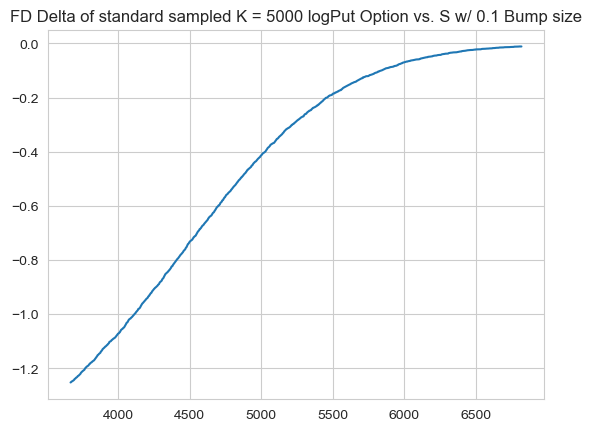

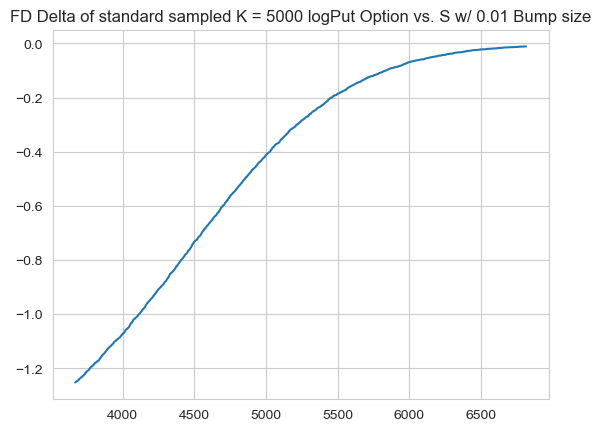

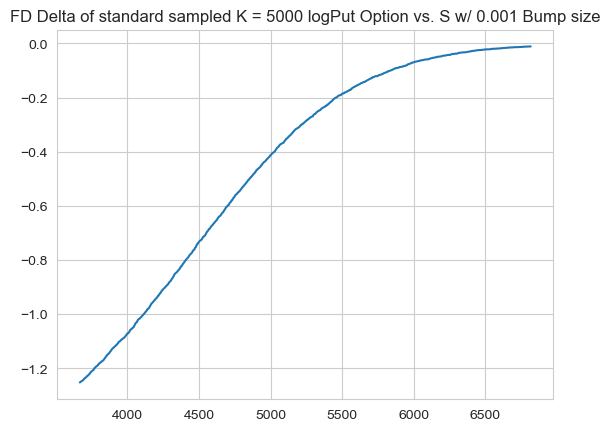

In [30]:
def plotDelta(samples, S, K, r, y, sigma, T, optionType = "logPut", method = "call", intervals = 1000, epsilon = 0.01):
    range_plus = K*np.exp(2*sigma*np.sqrt(T))
    range_minus = K*np.exp(-2*sigma*np.sqrt(T))
    deltas = []
    for i in np.linspace(range_minus, range_plus, intervals):
        S = i
        deltas.append(fd_delta_plus(samples, S, K, r, y, sigma, T, optionType, method, epsilon))
    sns.set_style("whitegrid")
    sns.lineplot(x=np.linspace(range_minus, range_plus, intervals), y=deltas)
    plt.title(f"FD Delta of {method} sampled K = {K} {optionType} Option vs. S w/ {epsilon} Bump size")
    plt.show()

for epsilon in [0.1, 0.01, 0.001]:
    plotDelta(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "logPut", "standard", 1000, epsilon)

In [31]:
def analyticalGammas(S, K, r, y, sigma, T, optionType = "logPut"):
    d1 = (np.log(S/K) + (r - y + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if optionType == "logPut":
        return np.exp(-y*T)*stats.norm.pdf(d1)/(S*sigma*np.sqrt(T))
    if optionType == "logCall":
        return np.exp(-y*T)*stats.norm.pdf(d1)/(S*sigma*np.sqrt(T))
    
    

def plotGamma(samples, S, K, r, y, sigma, T, optionType = "logPut", method = "call", intervals = 1000, epsilon = 0.01):
    range_plus = K*np.exp(2*sigma*np.sqrt(T))
    range_minus = K*np.exp(-2*sigma*np.sqrt(T))
    gammas = []
    for i in np.linspace(range_minus, range_plus, intervals):
        S = i
        gammas.append(fd_gamma(samples, S, K, r, y, sigma, T, optionType, method, epsilon))
    sns.set_style("whitegrid")
    sns.scatterplot(x=np.linspace(range_minus, range_plus, intervals), y=gammas)
    sns
    plt.title(f"FD Gamma of {method} sampled {optionType} Option vs. S w/ {epsilon} Bump size")
    plt.show()

for epsilon in [0.1, 0.01, 0.001]:
    plotGamma(sobol_3, default_S, default_K, default_r, default_y, default_sigma, default_T, "logPut", "standard", 1000, epsilon)

TypeError: simSwitch() missing 7 required positional arguments: 'K', 'r', 'y', 'sigma', 'T', 'optionType', and 'method'

# Problem 3:

In [ ]:
sobol_4_6 = sobolNormalGen(100000, 4)
sobol_12_6 = sobolNormalGen(100000, 12)
sobol_52_6 = sobolNormalGen(100000, 52)
sobol_252_6 = sobolNormalGen(100000, 252)

sobol_4_6_asset = stockSample(sobol_4_6, default_S, default_r, default_y, default_sigma, default_T)
sobol_12_6_asset = stockSample(sobol_12_6, default_S, default_r, default_y, default_sigma, default_T)
sobol_52_6_asset = stockSample(sobol_52_6, default_S, default_r, default_y, default_sigma, default_T)
sobol_252_6_asset = stockSample(sobol_252_6, default_S, default_r, default_y, default_sigma, default_T)


c:\Users\simon\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [ ]:


def deltas(stockSamples,  optionType, S=default_S, K=default_K, r=default_r, y=default_y, sigma=default_sigma, T=default_T):
    t = np.arange(0, T, T / stockSamples.shape[1]).reshape(-1, 1).flatten()  # Generate time points
    d1 = (np.log(stockSamples / K) + (r - y + 0.5 * sigma ** 2) * T - t) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    if optionType == "call":
        print("call")
        delta_S = np.exp(-y * t) * stats.norm.cdf(d1)
        delta_K = -np.exp(-r * t) * stats.norm.cdf(d2)
    elif optionType == "put":
        print("put")
        delta_S = -np.exp(-y * T) * stats.norm.cdf(-1*d1)
        delta_K = np.exp(-r * T) * stats.norm.cdf(-1*d2)
    else:
        raise ValueError("Invalid optionType. Should be 'call' or 'put'.")
    return delta_S, delta_K

deltas_put = deltas(sobol_4_6_asset, optionType="put")
print(deltas_put[0])
print(deltas_put[1])





put
[[-0.36939016 -0.57818521 -0.96767738 -0.98906022 -0.98906028]
 [-0.36939016 -0.27048216 -0.82472498 -0.98822651 -0.98906028]
 [-0.36939016 -0.84199847 -0.98902569 -0.98906028 -0.98906028]
 ...
 [-0.36939016 -0.80793062 -0.98766316 -0.9890601  -0.98906028]
 [-0.36939016 -0.69771535 -0.94866572 -0.98904443 -0.98906028]
 [-0.36939016 -0.98034888 -0.98637508 -0.98906028 -0.98906028]]
[[0.41269899 0.60718583 0.93683335 0.9521811  0.95218113]
 [0.41269899 0.30605954 0.82082066 0.95160933 0.95218113]
 [0.41269899 0.83900611 0.95216116 0.95218113 0.95218113]
 ...
 [0.41269899 0.81061398 0.95127893 0.95218103 0.95218113]
 [0.41269899 0.71541595 0.92231376 0.95217124 0.95218113]
 [0.41269899 0.94646957 0.95040695 0.95218113 0.95218113]]


In [ ]:

def hedgeSimulator(stockSamples, S = default_S, K = default_K, r = default_r, y = default_y, sigma = default_sigma, T = default_T, optionType = "put", method = "standard", intervals = 252):
    delta_hedged_return = np.zeros(stockSamples.shape[0])
    delta_S, delta_K = deltas(stockSamples, optionType, S, K, r, y, sigma, T)
    print(delta_S[0,0], delta_K[0,0])
    cash_holding = K*delta_K[0,0] + S*delta_S[0,0]
    print(cash_holding)
    appreciation = np.exp(r*T/stockSamples.shape[1]) - 1
    # long dollar position at time j-1 to j
    cash_holding[:, 1:] = -delta_K[:, :-1] * K*appreciation + delta_S[:, :-1] * stockSamples[:, :-1] + cash_holding[:, :-1]
    delta_hedged_return = cash_holding[:,-1] - K*np.exp(-r*T)*np.maximum(K - stockSamples[:, -1], 0)
    return np.mean(delta_hedged_return)

hedge_returns_4_6 = hedgeSimulator(sobol_4_6_asset, default_S, default_K, default_r, default_y, default_sigma, default_T)
print("Hedge Returns 4-6:", hedge_returns_4_6)

# hedge_returns_12_6 = hedgeSimulator(sobol_12_6_asset, default_S, default_K, default_r, default_y, default_sigma, default_T)
# print("Hedge Returns 12-6:", hedge_returns_12_6)

# hedge_returns_52_6 = hedgeSimulator(sobol_52_6_asset, default_S, default_K, default_r, default_y, default_sigma, default_T)
# print("Hedge Returns 52-6:", hedge_returns_52_6)

# hedge_returns_252_6 = hedgeSimulator(sobol_252_6_asset, default_S, default_K, default_r, default_y, default_sigma, default_T)
# print("Hedge Returns 252-6:", hedge_returns_252_6)

put
-0.3693901635163745 0.4126989875340386
216.54412008832037


IndexError: invalid index to scalar variable.

In [ ]:
print(hedge_returns_4_6[0])
print(hedge_returns_12_6[0])
print(hedge_returns_52_6[0])
print(hedge_returns_252_6[0])

-126.94721587807497
-388.98169127741085
-405.4339384546475
-410.2983363910761


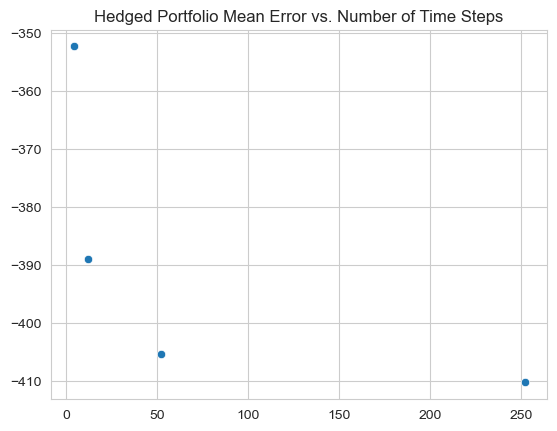

In [ ]:
x= [4, 12, 52, 252]
y = [hedge_returns_4_6[0], hedge_returns_12_6[0], hedge_returns_52_6[0], hedge_returns_252_6[0]]
sns.set_style("whitegrid")
sns.scatterplot(x=x, y=y)
plt.title("Hedged Portfolio Mean Error vs. Number of Time Steps")
plt.show()

y = [hedge_returns_4_6[2], hedge_returns_12_6[2], hedge_returns_52_6[2], hedge_returns_252_6[2]]
